In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools_core as et

In [2]:
model = 'geneva_200m'

In [3]:
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-01T22:00:00.000000000"

outputpath = "./99-Outputs/nencioli/"

# Open MITgcm results

In [4]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [5]:
grid_resolution_in_meter = ds_to_plot['XC'].values[1] - ds_to_plot['XC'].values[0]

In [6]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

# Generate psi contours

In [11]:
def compute_psi(u, v, dx, dy):
    # compute PSI to get eddy area
    # itegrate first row of v along longitude (first term of eq.A2)
    v_without_nan = np.where(np.isnan(v), 0, v)
    u_without_nan = np.where(np.isnan(u), 0, u)
    cx = np.nancumsum(v_without_nan[0, :] * dx[0, :])
    # integrate first column of u along latitude (second term of eq.A3)
    cy = np.nancumsum(u_without_nan[:, 0] * dy[:, 0])
    # compute streamfunction
    # PSI from integrating v first and then u
    psi_xy = -cx[None, :] + np.nancumsum(u_without_nan * dy, axis=0)
    # PSI from integrating u first and then v
    psi_yx = -np.nancumsum(v_without_nan * dx, axis=1) + cy[:, None]
    # final PSI as average between the two
    psi = 0.5 * (psi_xy + psi_yx)

    return np.where(np.isnan(u), np.nan, psi)

In [12]:
from contourpy import contour_generator

In [13]:
def generate_contours(lat, lon, psi):
    # Generate contour levels
    levels = np.linspace(np.nanmin(psi), np.nanmax(psi), 50)
    # Generate contours
    cg = contour_generator(lon, lat, psi)
    contours = [cg.lines(level) for level in levels]
    # Initialize structures
    isolines = {}
    isolines_max = []
    # Flatten and store contour line vertices
    idx = 0
    for contour_level in contours:
        for segment in contour_level:
            if len(segment[:, 0]) > 3:
                isolines[idx] = {
                    "x": segment[:, 0].tolist(),
                    "y": segment[:, 1].tolist()
                }
            isolines_max.append(np.nanmax(segment[:, 1]))
            idx += 1
    return isolines, isolines_max

In [14]:
t_index=3

In [15]:
snapshot = data_aligned.isel(time=t_index)
psi = compute_psi(snapshot['UVEL'].values, snapshot['VVEL'].values, snapshot['dxC'].values, snapshot['dyC'].values)
isolines, isolines_max = generate_contours(snapshot['lat'].values, snapshot['lon'].values, psi)

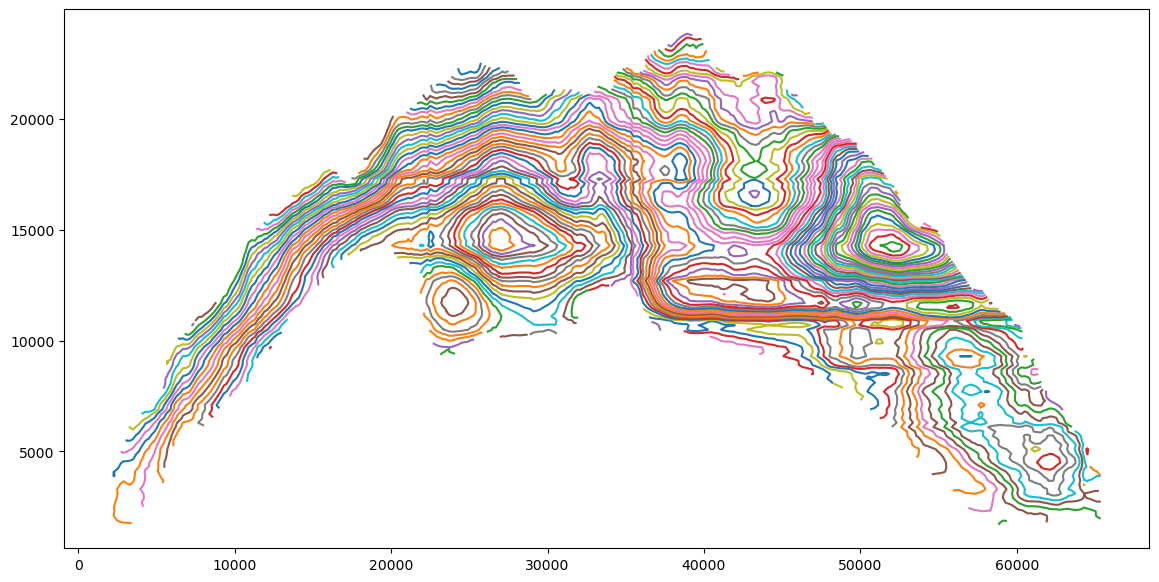

In [16]:
plt.figure(figsize=(14,7))
for i in isolines:
    iso = isolines[i]
    plt.plot(iso['x'], iso['y'])

In [17]:
snapshot = data_aligned.isel(time=t_index)
psi = compute_psi(snapshot['UVEL'].values, snapshot['VVEL'].values, snapshot['dxC'].values, snapshot['dyC'].values)
isolines, isolines_max = generate_contours(snapshot['lat'].values, snapshot['lon'].values, psi)

%matplotlib notebook
plt.figure(figsize=(14,7))

for i in isolines:
    iso = isolines[i]
    plt.plot(iso['x'], iso['y'])

subsetting_factor_x = 8
subsetting_factor_y = 4
X_trimmed = snapshot['lon'][::subsetting_factor_x]
Y_trimmed = snapshot['lat'][::subsetting_factor_y]
U_trimmed = snapshot['UVEL'][:,1:][::subsetting_factor_y,::subsetting_factor_x]
V_trimmed = snapshot['VVEL'][1:,:][::subsetting_factor_y,::subsetting_factor_x]

x_plot, y_plot = np.meshgrid(snapshot['lon'], snapshot['lat'])
u_plot = snapshot['UVEL'].values
v_plot = snapshot['VVEL'].values

stream_plot = plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=6, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

U_trimmed = U_trimmed.where(U_trimmed != 0, np.nan)
V_trimmed = V_trimmed.where(V_trimmed != 0, np.nan)
plt.quiver(X_trimmed, Y_trimmed, U_trimmed, V_trimmed, scale=100, zorder=50)

<IPython.core.display.Javascript object>

In [13]:
eddy_center_x, eddy_center_y = 43100, 16150
scale = 7
a = scale*500
snapshot = data_aligned.isel(time=t_index).sel(lon = slice(eddy_center_x-a,eddy_center_x+a), lat = slice(eddy_center_y-a,eddy_center_y+a))
psi = compute_psi(snapshot['UVEL'].values, snapshot['VVEL'].values, snapshot['dxC'].values, snapshot['dyC'].values)
isolines, isolines_max = generate_contours(snapshot['lat'].values, snapshot['lon'].values, psi)

%matplotlib notebook
plt.figure(figsize=(10,10))

for i in isolines:
    iso = isolines[i]
    plt.plot(iso['x'], iso['y'])


x_plot, y_plot = np.meshgrid(snapshot['lon'], snapshot['lat'])
u_plot = snapshot['UVEL'].values
v_plot = snapshot['VVEL'].values

stream_plot = plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=6, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(8,8))
stream_plot = plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=4, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

<IPython.core.display.Javascript object>

In [29]:
closed_isolines = {
    i: isoline for i, isoline in isolines.items()
    if isoline['x'][0] == isoline['x'][-1] and isoline['y'][0] == isoline['y'][-1]
}

In [49]:
all_x = np.concatenate([np.array(isoline['x']) for isoline in closed_isolines.values()])
all_y = np.concatenate([np.array(isoline['y']) for isoline in closed_isolines.values()])

x_min, x_max = np.min(all_x), np.max(all_x)
y_min, y_max = np.min(all_y), np.max(all_y)



In [70]:
buffer = 1000
x_window = max(eddy_center_x - x_min, x_max - eddy_center_x) + buffer
y_window = max(eddy_center_y - y_min, y_max - eddy_center_y) + buffer
snapshot = data_aligned.isel(time=t_index).sel(lon = slice(eddy_center_x-x_window,eddy_center_x+x_window), lat = slice(eddy_center_y-y_window,eddy_center_y+y_window))
psi = compute_psi(snapshot['UVEL'].values, snapshot['VVEL'].values, snapshot['dxC'].values, snapshot['dyC'].values)
isolines, isolines_max = generate_contours(snapshot['lat'].values, snapshot['lon'].values, psi)

closed_isolines = {
    i: isoline for i, isoline in isolines.items()
    if isoline['x'][0] == isoline['x'][-1] and isoline['y'][0] == isoline['y'][-1]
}

all_x = np.concatenate([np.array(isoline['x']) for isoline in closed_isolines.values()])
all_y = np.concatenate([np.array(isoline['y']) for isoline in closed_isolines.values()])

x_min, x_max = np.min(all_x), np.max(all_x)
y_min, y_max = np.min(all_y), np.max(all_y)

%matplotlib notebook
plt.figure(figsize=(8,8))

for i in closed_isolines:
    iso = closed_isolines[i]
    plt.plot(iso['x'], iso['y'])


x_plot, y_plot = np.meshgrid(snapshot['lon'], snapshot['lat'])
u_plot = snapshot['UVEL'].values
v_plot = snapshot['VVEL'].values

stream_plot = plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=6, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')



<IPython.core.display.Javascript object>

# Tests psi computation

In [20]:
u = snapshot['UVEL'].values
v = snapshot['VVEL'].values
dx = snapshot['dxC'].values
dy = snapshot['dyC'].values

# compute PSI to get eddy area
# itegrate first row of v along longitude (first term of eq.A2)
v_without_nan = np.where(np.isnan(v), 0, v)
u_without_nan = np.where(np.isnan(u), 0, u)
cx = np.nancumsum(v_without_nan[0, :] * dx[0, :])
# integrate first column of u along latitude (second term of eq.A3)
cy = np.nancumsum(u_without_nan[:, 0] * dy[:, 0])
# compute streamfunction
# PSI from integrating v first and then u
psi_xy = -cx[None, :] + np.nancumsum(u_without_nan * dy, axis=0)
# PSI from integrating u first and then v
psi_yx = -np.nancumsum(v_without_nan * dx, axis=1) + cy[:, None]
# final PSI as average between the two
psi = 0.5 * (psi_xy + psi_yx)

psi_masked = np.where(np.isnan(u), np.nan, psi)

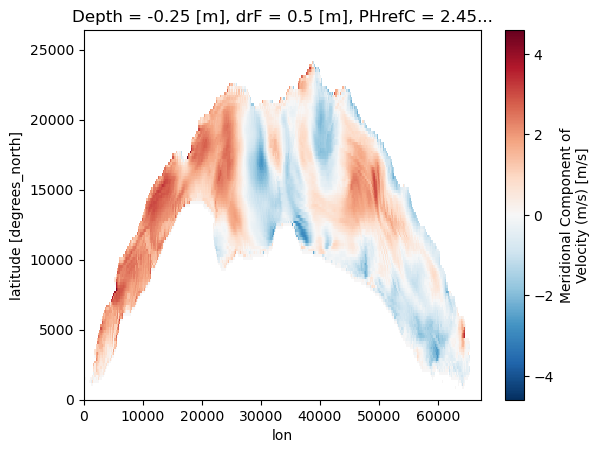

In [21]:
snapshot['VVEL'].plot()

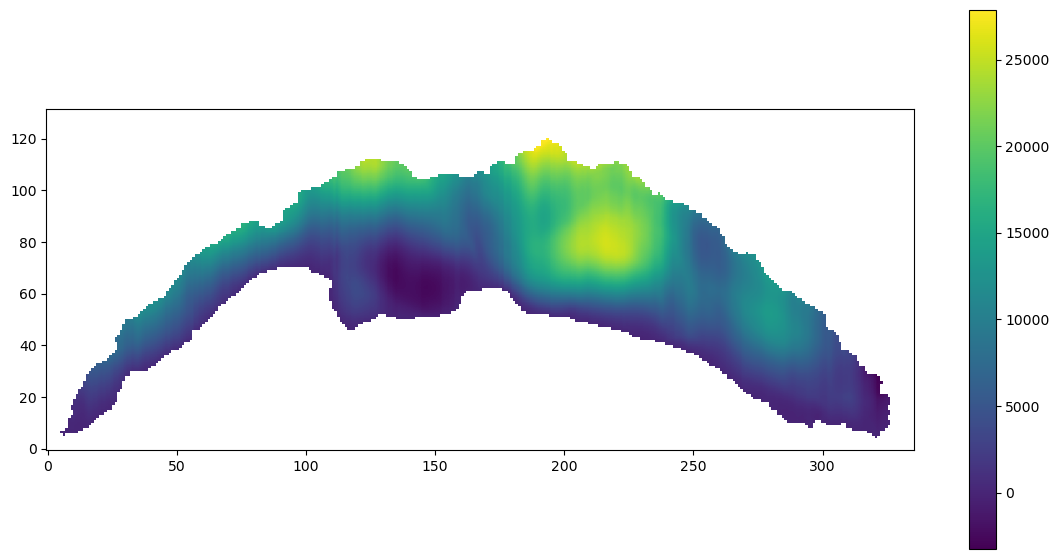

In [22]:
plt.figure(figsize=(14,7))
plt.imshow(np.where(np.isnan(u), np.nan, psi_xy))
plt.gca().invert_yaxis()
plt.colorbar()

In [23]:
psi_yx_without_nan = np.where(np.isnan(u), np.nan, psi_yx)

In [24]:
psi_yx_without_nan

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

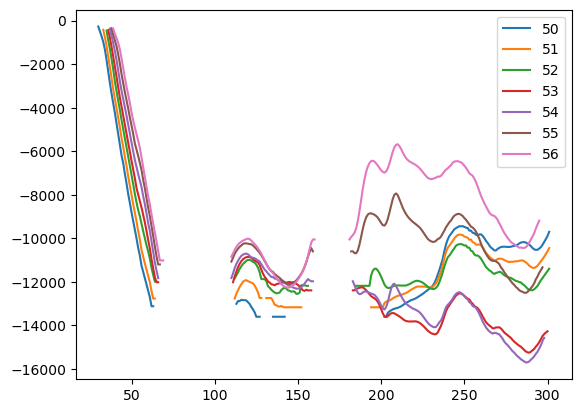

In [25]:
%matplotlib inline
plt.figure()
for i in range(50,57):
    plt.plot(psi_yx_without_nan[i,:], label=i)
    plt.legend()

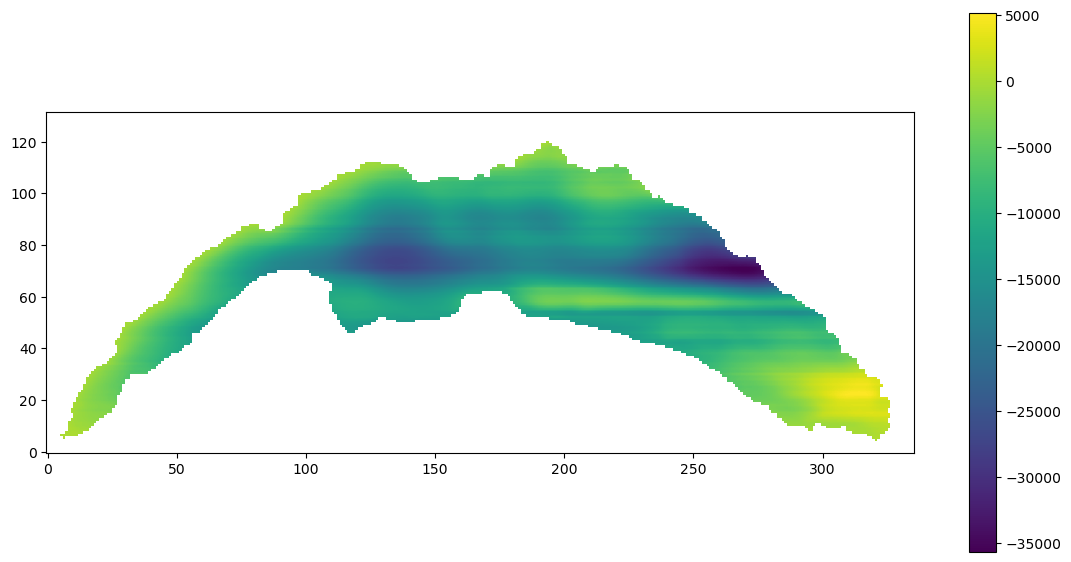

In [26]:
#%matplotlib notebook
plt.figure(figsize=(14,7))
plt.imshow(np.where(np.isnan(u), np.nan, psi_yx))
plt.gca().invert_yaxis()
plt.colorbar()

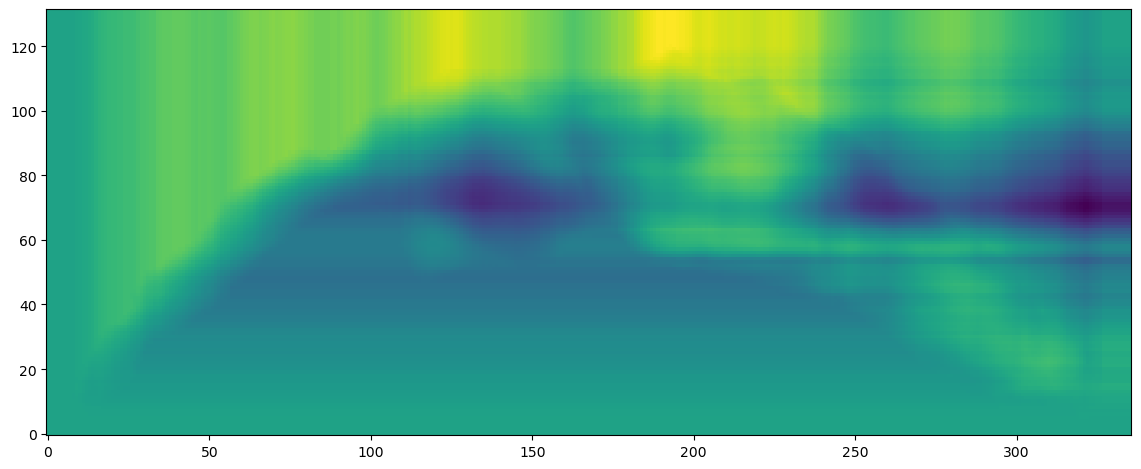

In [27]:
plt.figure(figsize=(14,7))
plt.imshow(psi)
plt.gca().invert_yaxis()